In [3]:
import numpy as np
from phe import paillier
import sys

# --- 1. Setup Phase ---
# Alice generates a public and private key pair.
# In a real-world scenario, this would be a distributed key generation.
public_key, private_key = paillier.generate_paillier_keypair()
print("Keys generated successfully.")

# --- 2. Data Preparation and Encryption Phase ---
# Assumes 'alice_data.txt' and 'bob_data.txt' are in the same directory.
# The files contain 3D coordinates.
try:
    alice_data = np.loadtxt('data/alice_data.txt')
    bob_data = np.loadtxt('data/bob_data.txt')
    if len(alice_data) != len(bob_data):
        raise ValueError("Data files must have the same number of rows.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure both data files exist.")
    sys.exit()
except ValueError as e:
    print(f"Error: {e}")
    sys.exit()

print(f"\nLoaded {len(alice_data)} data points for Alice.")
print(f"Loaded {len(bob_data)} data points for Bob.")

# Alice encrypts her data points
encrypted_alice_data = [[public_key.encrypt(coord) for coord in point] for point in alice_data]

# Bob encrypts his data points
encrypted_bob_data = [[public_key.encrypt(coord) for coord in point] for point in bob_data]
print("All data points have been encrypted.")


# --- 3. Computation Phase (Cloud Server) ---
# The cloud receives the encrypted data and performs computations.
encrypted_sed_results = []
for i in range(len(encrypted_alice_data)):
    # Get the encrypted points for the current iteration
    C_x_A, C_y_A, C_z_A = encrypted_alice_data[i]
    C_x_B, C_y_B, C_z_B = encrypted_bob_data[i]

    # Compute encrypted differences.
    C_delta_x = C_x_A - C_x_B
    C_delta_y = C_y_A - C_y_B
    C_delta_z = C_z_A - C_z_B

    # This is the simplified secure squaring step. The cloud sends
    # the encrypted differences to Alice, who decrypts, squares, and re-encrypts.
    # The cloud receives these new encrypted squares.
    sq_delta_x = private_key.decrypt(C_delta_x) ** 2
    sq_delta_y = private_key.decrypt(C_delta_y) ** 2
    sq_delta_z = private_key.decrypt(C_delta_z) ** 2

    C_sq_delta_x = public_key.encrypt(sq_delta_x)
    C_sq_delta_y = public_key.encrypt(sq_delta_y)
    C_sq_delta_z = public_key.encrypt(sq_delta_z)

    # The cloud computes the final encrypted SED using homomorphic addition.
    C_SED = C_sq_delta_x + C_sq_delta_y + C_sq_delta_z
    encrypted_sed_results.append(C_SED)
print("\nCloud computation complete. Results are still encrypted.")

# --- 4. Decryption Phase ---
# The cloud sends the list of encrypted results back to Alice.
# Alice uses her private key to decrypt all the results.
decrypted_sed_results = [private_key.decrypt(result) for result in encrypted_sed_results]
print("\nDecryption complete. Here are the final results:")

# Print the decrypted results and verify with a simple plaintext calculation
for i, result in enumerate(decrypted_sed_results):
    alice_point = alice_data[i]
    bob_point = bob_data[i]

    # Plaintext SED calculation for verification
    plaintext_sed = np.sum((alice_point - bob_point) ** 2)

    print(f"Pair {i+1}: SED = {result:.2f} (Verified: {plaintext_sed:.2f})")

Keys generated successfully.

Loaded 3 data points for Alice.
Loaded 3 data points for Bob.
All data points have been encrypted.

Cloud computation complete. Results are still encrypted.

Decryption complete. Here are the final results:
Pair 1: SED = 75.00 (Verified: 75.00)
Pair 2: SED = 81.00 (Verified: 81.00)
Pair 3: SED = 33.00 (Verified: 33.00)



Generating visualizations...


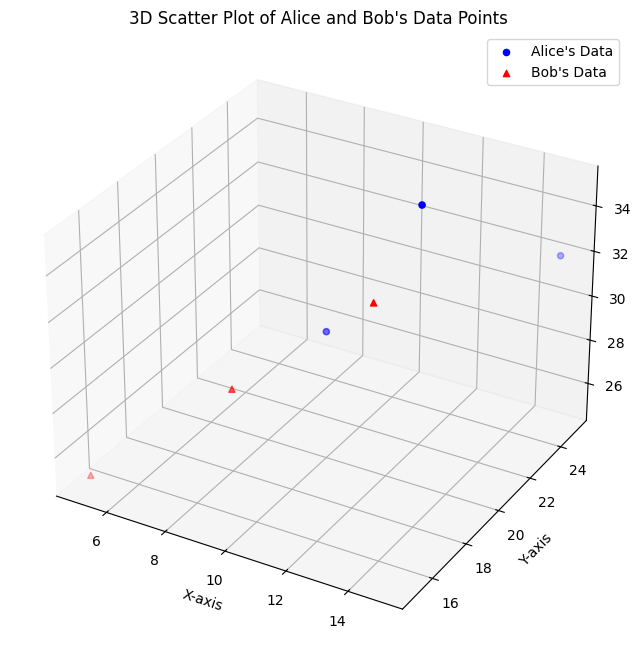

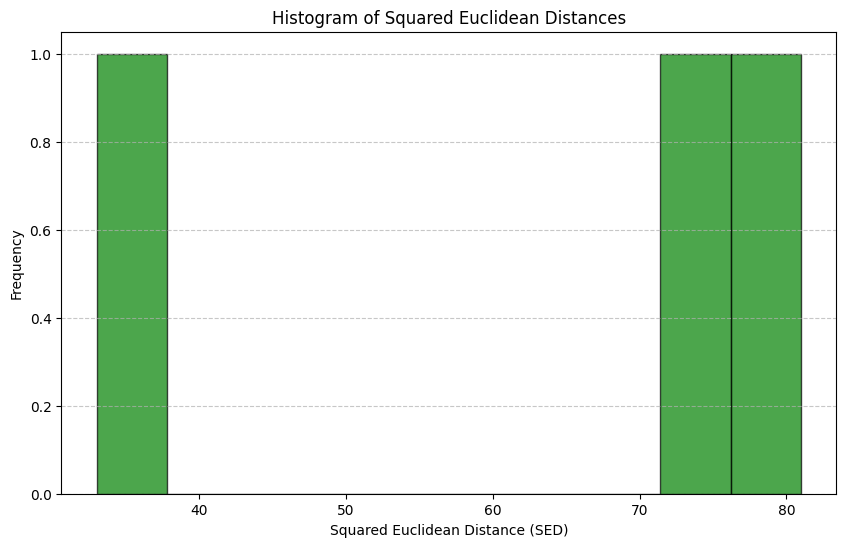

Visualizations complete.


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Visualization Phase ---
print("\nGenerating visualizations...")

# --- 1. 3D Scatter Plot of Data Points ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Alice's data in blue
ax.scatter(alice_data[:, 0], alice_data[:, 1], alice_data[:, 2],
           c='blue', marker='o', label="Alice's Data")

# Plot Bob's data in red
ax.scatter(bob_data[:, 0], bob_data[:, 1], bob_data[:, 2],
           c='red', marker='^', label="Bob's Data")

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Scatter Plot of Alice and Bob\'s Data Points')
ax.legend()
plt.savefig('plots/3d_scatter_plot.png', dpi=300)
plt.show()

# --- 2. Histogram of Squared Euclidean Distances ---
plt.figure(figsize=(10, 6))
plt.hist(decrypted_sed_results, bins=10, color='green', edgecolor='black', alpha=0.7)
plt.title('Histogram of Squared Euclidean Distances')
plt.xlabel('Squared Euclidean Distance (SED)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('plots/SquaredEuclideanDistancesHisto.png')
plt.show()

print("Visualizations complete.")